# Setup

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import glob
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt
from tqdm import tqdm

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from utils import (
    run_kmeans, 
    diverse_sample, 
    sample_kmeans_upto, 
    get_rand_csvs, 
    load_all_features
)

# Get main csv

In [2]:
file_path_main = "/local_disk/apollon/rwhetten/loquacious_medium_train.csv"
main_df = pd.read_csv(file_path_main)
main_df.duration.sum() / 3600

/tmp/ipykernel_14739/716921408.py:2: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  main_df = pd.read_csv(file_path_main)


2499.983254778439

# Check audio in random

In [3]:
file_path_rand = "/local_disk/apollon/rwhetten/sss_data_selection/sample/csvs/loq_medium/random_0.5.csv"
df = pd.read_csv(file_path_rand)
df.duration.sum() / 3600

1249.846003866489

# get speaker clusters

In [4]:
file_path_clust = "/local_disk/apollon/rwhetten/sss_data_selection/sample/csvs/loq_medium/speaker_clusters_medium_150.csv"
df = pd.read_csv(file_path_clust, index_col=0)
df.head()

,ID,cluster
0,snafuinfinityfootball_vsWOBURN_092118-CL19_SLA...,132
1,Grad2009_SLASH_Grad2009_DOT_mp3_00006.flac,120
2,texas_terror_1935_SLASH_texas_terror_1935_DOT_...,132
3,unfinished_task_SLASH_unfinished_task_DOT_mp3_...,132
4,gov_DOT_uscourts_DOT_ca3_DOT_19-2975_SLASH_gov...,119


In [5]:
main_df.head()

,ID,duration,wav,spk_id,sex,text
0,20091124-0900-PLENARY-18-en_20091124-22:35:55_9,17.120000,20091124-0900-PLENARY-18-en_20091124-22:35:55_...,1309,male,AND WHAT ABOUT INTEROPERABILITY IN THE RAIL SE...
1,20171024-0900-PLENARY-19-en_20171024-19:35:50_20,13.579937,20171024-0900-PLENARY-19-en_20171024-19:35:50_...,NaN,male,THIS WILL NOT HAPPEN THIS IS A PROMISE I MAKE ...
2,20150520-0900-PLENARY-8-en_20150520-13:27:12_5,9.797000,20150520-0900-PLENARY-8-en_20150520-13:27:12_5...,124985,male,IT IS GOOD TO SEE SOMETHING BEING DONE ABOUT I...
3,20170613-0900-PLENARY-9-en_20170613-13:02:00_0,16.377250,20170613-0900-PLENARY-9-en_20170613-13:02:00_0...,28115,female,MR PRESIDENT I WANT TO PUT ON THE RECORD MY SU...
4,20170911-0900-PLENARY-16-en_20170911-18:23:37_6,6.759938,20170911-0900-PLENARY-16-en_20170911-18:23:37_...,96897,male,POLITICAL CORRECTNESS IS THE CORNERSTONE OF TH...


In [6]:
df_merged = df.merge(main_df[["ID", "duration"]], on="ID", how="left")
df_merged.head()

,ID,cluster,duration
0,snafuinfinityfootball_vsWOBURN_092118-CL19_SLA...,132,1.17
1,Grad2009_SLASH_Grad2009_DOT_mp3_00006.flac,120,1.02
2,texas_terror_1935_SLASH_texas_terror_1935_DOT_...,132,1.20
3,unfinished_task_SLASH_unfinished_task_DOT_mp3_...,132,1.17
4,gov_DOT_uscourts_DOT_ca3_DOT_19-2975_SLASH_gov...,119,1.71


In [7]:
df_merged[df_merged.cluster == 89].duration.sum() / 3600

24.824260368421672

In [8]:
def diverse_sample_longest(cluster_df, frac, random_state=0):
    N = int(len(cluster_df) * frac)
    k = len(cluster_df['cluster'].unique())
    labels = cluster_df['cluster']
    clusters = [np.where(labels == i)[0] for i in range(k)]
    cluster_sizes = [len(c) for c in clusters]

    # Step 1: Allocate at least one per cluster (if cluster is non-empty)
    allocated = [min(1, size) for size in cluster_sizes]
    remaining = N - sum(allocated)

    # Step 2: Distribute remaining not propotionally (capped by cluster size)
    total_remaining_capacity = sum(max(size - alloc, 0) for alloc, size in zip(allocated, cluster_sizes))
    i = 1
    done = False
    while not done:
        for i in range(k):
            cap = max(cluster_sizes[i] - allocated[i], 0)
            if cap > 0:
                allocated[i] += 1
                remaining -= 1
            if remaining <= 0:
                done = True
                break

    sampled_indices = []
    for i, count in enumerate(allocated):
        if count > 0:
            X_cluster = cluster_df[cluster_df.cluster == i]
            X_cluster_sorted = X_cluster.sort_values("duration", ascending=False)
            sampled_indices.extend(list(X_cluster_sorted[:count].ID))
            
    return sampled_indices

In [9]:
ids = diverse_sample_longest(df_merged, 0.31)

In [10]:
filtered_main_df = main_df[main_df['ID'].isin(ids)]

In [11]:
print(f"{len(filtered_main_df)} files and {round((filtered_main_df.duration.sum()/ 3600), 2)} hours")


332975 files and 1243.75 hours


# Save csv

<Axes: >

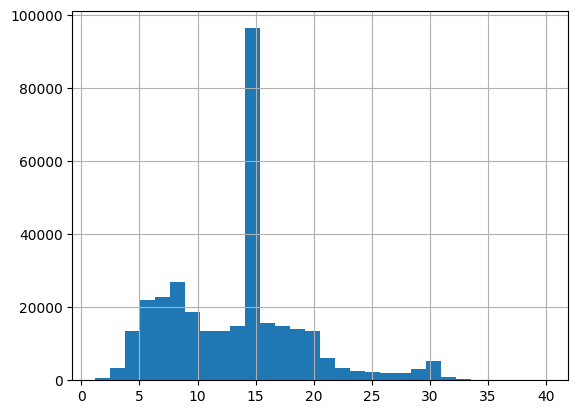

In [12]:
filtered_main_df.duration.hist(bins=30)

In [13]:
filtered_main_df.to_csv("/local_disk/apollon/rwhetten/sss_data_selection/sample/csvs/loq_medium/speaker_len_0.5.csv")

In [14]:
df = pd.read_csv("/local_disk/apollon/rwhetten/sss_data_selection/sample/csvs/loq_medium/length_0.5.csv")

<Axes: >

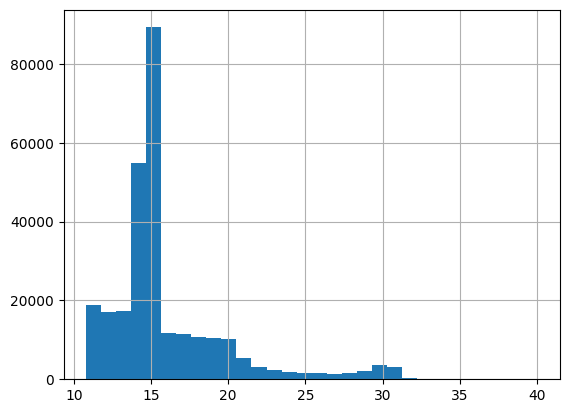

In [15]:
df.duration.hist(bins=30)

In [16]:
df = pd.read_csv("/local_disk/apollon/rwhetten/sss_data_selection/sample/csvs/loq_medium/random_0.5.csv")

<Axes: >

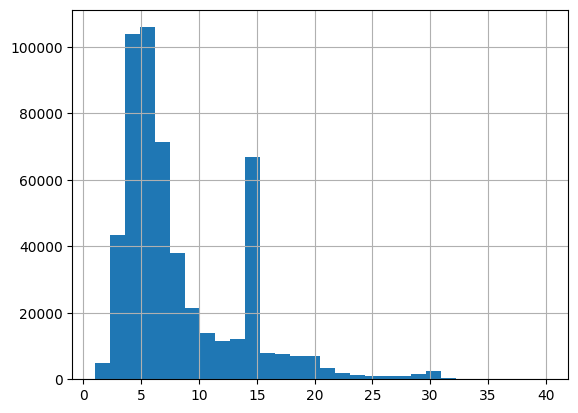

In [17]:
df.duration.hist(bins=30)